<a href="https://colab.research.google.com/github/chaitraDev/GenAI-for-marketing/blob/main/Cognizant_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
num_clusters = 51
num_rows = 1_00_000

# Setup

In [ ]:
import pandas as pd

In [ ]:
customers = pd.read_csv("/content/drive/MyDrive/Cognizant/customers_segmented_p2.csv")

In [ ]:
customers.columns

Index(['Unnamed: 0', 'CustomerID', 'CustGender', 'CustLocation',
       'CustAccountBalance', 'most_recent', 'Gap', 'Num_Transactions',
       'Sum_Transactions', 'Recency', 'Monetary_Value', 'Frequency',
       'RFM_Score', 'Relationship_Value', 'Age', 'Cibil_Score', 'Income',
       'Product'],
      dtype='object')

In [ ]:
# customers = customers.iloc[:num_rows,:]

In [ ]:
# the columns we need gender, age, income, cibil, relationship value
customers_req = customers[[ 'Age', 'Income','Cibil_Score', 'RFM_Score', 'Relationship_Value', 'Product']]

In [ ]:
customers[customers.Relationship_Value.isnull()]

,Unnamed: 0,CustomerID,CustGender,CustLocation,CustAccountBalance,most_recent,Gap,Num_Transactions,Sum_Transactions,Recency,Monetary_Value,Frequency,RFM_Score,Relationship_Value,Age,Cibil_Score,Income,Product


# Transforming

In [ ]:
customers_req.select_dtypes('O').columns

Index(['Relationship_Value', 'Product'], dtype='object')

- Relationship_Value is ordinal
- Location is nominal

## Relationship value column

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# lbl_encoder = LabelEncoder()
# customers_req.loc[:,"Relationship_Value(num)"] = lbl_encoder.fit_transform(customers_req["Relationship_Value"])
customers_req.loc[:,"Relationship_Value(num)"] = customers_req["Relationship_Value"].map({"high":2,"med":1,"low":0})

<ipython-input-13-f1de21af0a84>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_req.loc[:,"Relationship_Value(num)"] = customers_req["Relationship_Value"].map({"high":2,"med":1,"low":0})


In [ ]:
customers_req[["Relationship_Value","Relationship_Value(num)"]].head(4)

,Relationship_Value,Relationship_Value(num)
0,high,2
1,low,0
2,low,0
3,low,0


In [ ]:
customers_req.columns

Index(['Age', 'Income', 'Cibil_Score', 'RFM_Score', 'Relationship_Value',
       'Product', 'Relationship_Value(num)'],
      dtype='object')

## Products Column

In [ ]:
from sklearn.preprocessing import LabelEncoder
lbl_encoder = LabelEncoder()
customers_req.loc[:,"Product"] = lbl_encoder.fit_transform(customers_req["Product"])

# Normalization

In [ ]:
cust_numeric = customers_req[["Age","Income","Cibil_Score","RFM_Score","Relationship_Value(num)","Product"]] # was good with relationship value and no RFM score

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cust_numeric = pd.DataFrame(scaler.fit_transform(cust_numeric),columns=cust_numeric.columns)

In [ ]:
cust_numeric.isnull().sum()

,0
Age,0
Income,0
Cibil_Score,0
RFM_Score,0
Relationship_Value(num),0
Product,0


# K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
X = cust_numeric

In [ ]:
def score_kmeans(data,model,metric):
  return metric(data,model.labels_)

In [ ]:
kmeans = KMeans(num_clusters,random_state=144)
kmeans.fit(X)
clusters = kmeans.labels_

# Scoring

In [ ]:
from sklearn.metrics import davies_bouldin_score as dbs

In [ ]:
score_kmeans(X,kmeans,dbs)

1.1507324322840606

In [ ]:
from sklearn.metrics import calinski_harabasz_score
score_kmeans(X,kmeans,calinski_harabasz_score)

239133.01884936678

In [ ]:
len(customers_req.clusters.unique())

51

# Saving

In [ ]:
customers_req["clusters"] = clusters

<ipython-input-26-1fb8b470fb07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_req["clusters"] = clusters


In [ ]:
cust_to_save = customers_req.loc[:,["Age","Income","Cibil_Score","Relationship_Value","Product","clusters"]]

In [ ]:
cust_to_save.to_csv("cust_segmented_clustered.csv",index=False)

In [ ]:
import joblib
joblib.dump(kmeans,"/content/kmeans1.pkl")

['/content/kmeans1.pkl']

# Analyzing

In [ ]:
cust_to_save.columns

Index(['Age', 'Income', 'Cibil_Score', 'Relationship_Value', 'Product',
       'clusters'],
      dtype='object')

# Visualizing

In [ ]:
temp = customers[((customers.Product != "Recurring Deposit") & (customers.Product != "Senior Citizens Health Insurance") & (customers.Product !="National_Pension_System"))]

<Axes: xlabel='Product'>

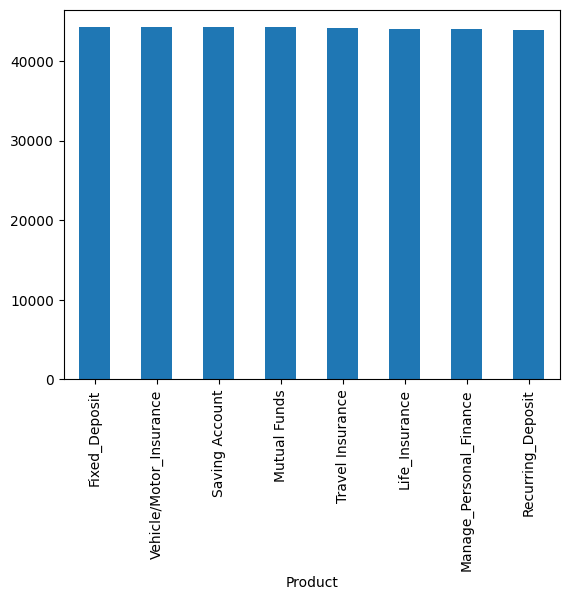

In [ ]:
temp.Product.value_counts().plot(kind="bar")

In [ ]:
import seaborn as sns
sns.barplot(x="")